# Grand Junction
this notebook provides a simple template for basic risk based flood analysis

## Import and visualize the input data
### 1. set the input data directory and file names

In [19]:
data_directory: str = 'C:/Users/q0hecjrk/Documents/_Projects/grandjunction/data/'
terrain_file: str = 'terrain.tif' # a GeoTiff raster file containing terraing data
inventory_file: str = 'inventory.shp' # a point shape file containing structure data
floodplain_500_file: str = '500yr.tif' # watersurface elvation GeoTiff raster for 500 year floodplain

### 2. terrain data

In [20]:
import rasterio as rio
import earthpy.plot as ep
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent

dataset = rio.open(data_directory + terrain_file) # open the terrain data
print('terrain.tif: {bands: ' + str(dataset.count) + ', width: ' + str(dataset.width) + ', height: ' + str(dataset.height) + '}')
terrain = dataset.read(1, masked = True) # read in single band of data containing ground elevations

terrain.tif: {bands: 1, width: 4717, height: 2544}


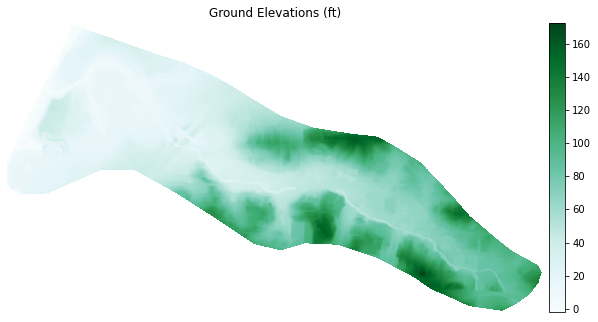

In [21]:
fig, ax = plt.subplots(figsize=(10, 10)) # The next few lines plot the terrain data
ep.plot_bands(terrain, extent=plotting_extent(dataset), cmap='BuGn', title="Ground Elevations (ft)", scale=False, ax=ax)
ax.set_axis_off()
plt.show()

### 3. structure inventory data

In [22]:
import geopandas
from IPython.display import display, HTML

inventory = geopandas.read_file(data_directory + inventory_file)
inventory.head() # the quickest smallest view of the data
#display(inventory) # a more expansive view of the data (more rows)
#display(HTML(inventory.to_html())) # the most expansive view of the data

,St_Name,DamCat,OccType,Found_Ht,Ground_Ht,FFE,UseFFE,UseDBF_GE,Val_Struct,Val_Cont,Val_Other,Yr_Built,Begin_Dmg,Num_Struct,Mod_Name,geometry
0,544,Public,EDU1,15.45002,0.0,15.45002,1,0,963.686727,732.825935,0.0,0,0.0,0,Base,POINT (1326157.004 449856.178)
1,545,Public,EDU1,16.17769,0.0,16.17769,1,0,2774.830180,2110.091862,0.0,0,0.0,0,Base,POINT (1325938.070 449653.811)
2,546,Residential,RES3BI,87.39378,0.0,87.39378,1,0,705.611868,352.805934,0.0,0,0.0,0,Base,POINT (1337103.865 446017.836)
3,547,Residential,RES1-2SNB,17.49375,0.0,17.49375,1,0,512.303617,256.151808,0.0,0,0.0,0,Base,POINT (1326103.630 449549.042)
4,548,Residential,RES1-2SNB,17.35625,0.0,17.35625,1,0,519.882411,259.941206,0.0,0,0.0,0,Base,POINT (1326153.663 449598.431)


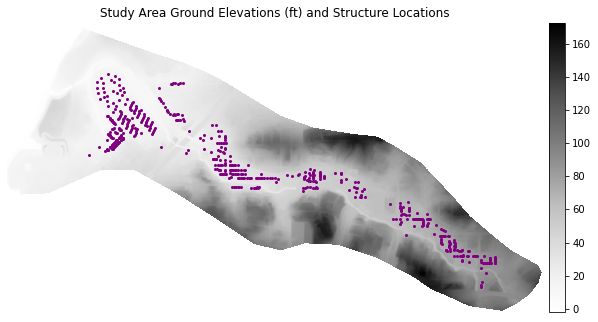

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ep.plot_bands(terrain, extent=plotting_extent(dataset), cmap='Greys', title="Study Area Ground Elevations (ft) and Structure Locations", scale=False, ax=ax)
inventory.plot(ax=ax, marker='o', markersize=4,  color='purple')
ax.set_axis_off()
plt.show()

### 4. hydraulic data
Below I import a single floodplain raster, this needs to be repeated for the other floodplains of interest.

In [24]:
dataset = rio.open(data_directory + floodplain_500_file)
print('500yr.tif: {bands: ' + str(dataset.count) + ', width: ' + str(dataset.width) + ', height: ' + str(dataset.height) + '}')
floodplain500 = dataset.read(1, masked = True) # read in single band of data containing 500 year floodplain water surface elvations

500yr.tif: {bands: 1, width: 4717, height: 2544}


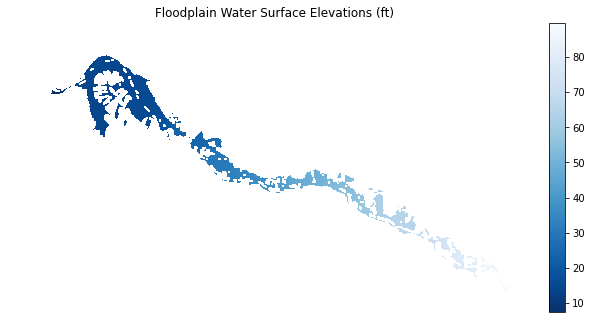

In [25]:
fig, ax = plt.subplots(figsize=(10, 10)) # The next few lines plot the terrain data
ep.plot_bands(floodplain500, extent=plotting_extent(dataset), cmap='Blues_r', title="Floodplain Water Surface Elevations (ft)", scale=False, ax=ax)
ax.set_axis_off()
plt.show()

In [26]:
## Joint raster (elevation, floodplain) and point (inventory) data

In [27]:
from rasterstats import zonal_stats, point_query

inventory['elevation'] = -999
elevation_array = point_query(inventory, data_directory + terrain_file)
for i, row in inventory.iterrows():
    inventory.loc[i, 'elevation'] = elevation_array[i]
inventory.head()
# a few things to check:
# (1) are there 'missing' values in the elevation_array - or can we set them to a value we will know means the value was 'missing'
# (2) the elevation_array and inventory have the same number of rows - if they didn't this would fail
# (3) I assume the elevation_array and inventory rows are in the same order but this should be spot checked

,St_Name,DamCat,OccType,Found_Ht,Ground_Ht,FFE,UseFFE,UseDBF_GE,Val_Struct,Val_Cont,Val_Other,Yr_Built,Begin_Dmg,Num_Struct,Mod_Name,geometry,elevation
0,544,Public,EDU1,15.45002,0.0,15.45002,1,0,963.686727,732.825935,0.0,0,0.0,0,Base,POINT (1326157.004 449856.178),15.807789
1,545,Public,EDU1,16.17769,0.0,16.17769,1,0,2774.830180,2110.091862,0.0,0,0.0,0,Base,POINT (1325938.070 449653.811),16.628332
2,546,Residential,RES3BI,87.39378,0.0,87.39378,1,0,705.611868,352.805934,0.0,0,0.0,0,Base,POINT (1337103.865 446017.836),86.798032
3,547,Residential,RES1-2SNB,17.49375,0.0,17.49375,1,0,512.303617,256.151808,0.0,0,0.0,0,Base,POINT (1326103.630 449549.042),17.197719
4,548,Residential,RES1-2SNB,17.35625,0.0,17.35625,1,0,519.882411,259.941206,0.0,0,0.0,0,Base,POINT (1326153.663 449598.431),17.105835
